In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

In [ ]:
train_img_Path = '/content/drive/MyDrive/Python Scripts/Saturday AI/Clasificación/Data Limpia/train'
valid_img_Path = '/content/drive/MyDrive/Python Scripts/Saturday AI/Clasificación/Data Limpia/valid' 
test_img_Path= '/content/drive/MyDrive/Python Scripts/Saturday AI/Clasificación/Data Limpia/test'  

In [ ]:
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
   train_img_Path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
) 
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
   test_img_Path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
 

Found 2654 files belonging to 2 classes.
Found 280 files belonging to 2 classes.


In [ ]:
train_ds.class_names

['Autistic', 'Non_Autistic']

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
) 

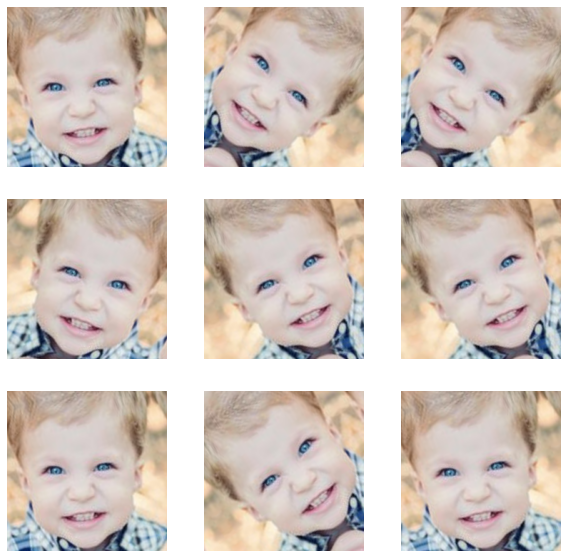

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)  

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=test_ds, 
) 

Epoch 1/50
83/83 [==============================] - 414s 5s/step - loss: 0.6712 - accuracy: 0.6334 - val_loss: 0.6915 - val_accuracy: 0.5000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
83/83 [==============================] - 31s 369ms/step - loss: 0.5807 - accuracy: 0.7016 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 3/50
83/83 [==============================] - 31s 371ms/step - loss: 0.5506 - accuracy: 0.7246 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 4/50
83/83 [==============================] - 32s 377ms/step - loss: 0.5527 - accuracy: 0.7257 - val_loss: 0.7143 - val_accuracy: 0.5000
Epoch 5/50
83/83 [==============================] - 32s 382ms/step - loss: 0.5231 - accuracy: 0.7430 - val_loss: 0.7493 - val_accuracy: 0.5000
Epoch 6/50
83/83 [==============================] - 33s 384ms/step - loss: 0.5274 - accuracy: 0.7506 - val_loss: 0.6978 - val_accuracy: 0.5071
Epoch 7/50
83/83 [==============================] - 33s 386ms/step - loss: 0.5173 - accuracy: 0.7562 - val_loss: 0.4398 - val_accuracy: 0.8000
Epoch 8/50
83/83 [==============================] - 33s 388ms/step - loss: 0.5011 - accuracy: 0.7589 - val_loss: 0.4111 - val_accuracy: 0.8071

In [ ]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
   train_img_Path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
) 

test_loss, test_acc = model.evaluate(valid_ds)
print("Test image accuracy :{}".format(test_acc))  

Found 80 files belonging to 2 classes.
3/3 [==============================] - 10s 372ms/step - loss: 0.3351 - accuracy: 0.8750
Test image accuracy :0.875


In [ ]:
import sys
import os

dir = '/content/drive/MyDrive/Python Scripts/Saturday AI/Clasificación/ModeloPreEntrenadoDataLimpia/'

if not os.path.exists(dir):
  os.mkdir(dir)

model.save('/content/drive/MyDrive/Python Scripts/Saturday AI/Clasificación/ModeloPreEntrenadoDataLimpia/modelo.h5') 
model.save_weights('/content/drive/MyDrive/Python Scripts/Saturday AI/Clasificación/ModeloPreEntrenadoDataLimpia/pesos.h5')   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
